<a href="https://www.kaggle.com/code/kmljts/real-time-video-dehazing-using-lightclearnet?scriptVersionId=182255953" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Real-time Video Dehazing using LightClearNet

Original work on GitHub: <https://github.com/kmljt/LightClearNet/blob/main/realtime_dehazing.ipynb>  
LightClearNet model page: <https://www.kaggle.com/models/kmljts/lightclearnet>  
LightClearNet training notebook: <https://www.kaggle.com/code/kmljts/lightclearnet>

### **Improvements**
- Rewrote the dehazing logic without using PIL for better performance.
- Integrated PyTube to use any YouTube video without even downloading.
- Quick display and removal of frames feels like running a video natively (work-around as `cv2.imshow()` was not working).

### **To-do**
- Listen to keyboard input to control video's flow.
- Implement frame skipping during video playback to maintain a stable video FPS when the number of frames getting dehazed per second is lower.

In [1]:
!pip list | grep opencv

opencv-contrib-python                    4.9.0.80
opencv-python                            4.9.0.80
opencv-python-headless                   4.9.0.80


In [2]:
!pip install pytube

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 2.3 MB/s eta 0:00:00


In [3]:
import torch
from torchvision import transforms
import cv2
import numpy as np

from pytube import YouTube
from IPython.display import display, clear_output, Image
from timeit import default_timer as timer
import time
from tqdm.auto import tqdm

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

device

device(type='cuda')

In [5]:
model_loc = '/kaggle/input/lightclearnet/pytorch/7epochs-21.2462-85.50/1/full-model-jit.pth'
model = torch.jit.load(model_loc, map_location=device).to(device)
model.__class__.__name__ = model.original_name

model

LightClearNet(
  original_name=LightClearNet
  (enc_conv1): LightClearNet(original_name=Conv2d)
  (enc_bn1): LightClearNet(original_name=BatchNorm2d)
  (enc_conv2): LightClearNet(original_name=Conv2d)
  (enc_bn2): LightClearNet(original_name=BatchNorm2d)
  (enc_conv3): LightClearNet(original_name=Conv2d)
  (enc_bn3): LightClearNet(original_name=BatchNorm2d)
  (dec_conv1): LightClearNet(original_name=Conv2d)
  (dec_bn1): LightClearNet(original_name=BatchNorm2d)
  (dec_conv2): LightClearNet(original_name=Conv2d)
  (dec_bn2): LightClearNet(original_name=BatchNorm2d)
  (dec_conv3): LightClearNet(original_name=Conv2d)
)

In [6]:
def cv2_frame_to_img(frame):
    return Image(cv2.imencode('.jpg', frame)[1])

def resize_frame(frame, height):
    h, w, c = frame.shape
    scale = height / float(h)
    width = int(w * scale)
    
    return cv2.resize(frame, (width, height))

def frame_dehazer(frame, resize=False):
    if resize:
        frame = resize_frame(frame, height=400)
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB).astype(np.float32)
    frame_rgb /= 255.0
    tensor = transforms.ToTensor()(frame_rgb).unsqueeze(0).to(device)
    
    model.eval()
    with torch.inference_mode():
        pred = model(tensor).squeeze(0)
    
    pred = pred.permute(1, 2, 0)
    dehazed_frame = pred.cpu().numpy()
    dehazed_frame = (dehazed_frame * 255.0).astype(np.uint8)
    dehazed_frame = cv2.cvtColor(dehazed_frame, cv2.COLOR_BGR2RGB)
    
    new_frame = cv2.hconcat([frame, dehazed_frame])
    return new_frame

In [7]:
yt_urls = {
    'dark_forest': 'https://www.youtube.com/watch?v=LVanPoKh7Ew',
    'autumn_forest': 'https://www.youtube.com/watch?v=USa5se_T7TE',
    'bright_forest': 'https://www.youtube.com/watch?v=DhsKd0Ln0M8',
    'short_clip': 'https://www.youtube.com/watch?v=SgFkqkB6nvM',
    'light_fog': 'https://www.youtube.com/watch?v=-pIkWiNJikw',
    'almost_still_vid_1': 'https://www.youtube.com/watch?v=8plwv25NYRo',
    'almost_still_vid_2': 'https://www.youtube.com/watch?v=yCykHHqk_z0',
}

yt_urls

{'dark_forest': 'https://www.youtube.com/watch?v=LVanPoKh7Ew',
 'autumn_forest': 'https://www.youtube.com/watch?v=USa5se_T7TE',
 'bright_forest': 'https://www.youtube.com/watch?v=DhsKd0Ln0M8',
 'short_clip': 'https://www.youtube.com/watch?v=SgFkqkB6nvM',
 'light_fog': 'https://www.youtube.com/watch?v=-pIkWiNJikw',
 'almost_still_vid_1': 'https://www.youtube.com/watch?v=8plwv25NYRo',
 'almost_still_vid_2': 'https://www.youtube.com/watch?v=yCykHHqk_z0'}

In [8]:
url = yt_urls['almost_still_vid_2']

yt = YouTube(url)
stream = yt.streams.get_highest_resolution()
# stream = yt.streams.filter(res='480p').first()
# stream = yt.streams.first()

stream

<Stream: itag="22" mime_type="video/mp4" res="720p" fps="25fps" vcodec="avc1.64001F" acodec="mp4a.40.2" progressive="True" type="video">

In [9]:
stream.title, stream.default_filename, stream.resolution, stream.fps
# stream.download()

('Winter Wind Sounds 1 Hour / High Winds Blowing Snow',
 'Winter Wind Sounds 1 Hour  High Winds Blowing Snow.mp4',
 '720p',
 25)

In [10]:
stream_fps = stream.fps
stream_url = stream.url

stream_fps, stream_url

(25,
 'https://rr1---sn-qxoednee.googlevideo.com/videoplayback?expire=1717890968&ei=OJtkZreqB9q9sfIP8ICn-Ao&ip=34.127.75.37&id=o-ACVKh8G4UVbW1iCwxvbKTJdkzbtONvj8ha3kBlE_hmbH&itag=22&source=youtube&requiressl=yes&xpc=EgVo2aDSNQ%3D%3D&mh=LQ&mm=31%2C26&mn=sn-qxoednee%2Csn-a5m7lnl6&ms=au%2Conr&mv=m&mvi=1&pl=20&initcwndbps=3127500&bui=AbKP-1M7P68KhStNbrKR8vPRf7jQeyXvF3fV00psWEvFTmLdoL9GLy7UOtcB8KgEct3cra9-l00Hi122&vprv=1&mime=video%2Fmp4&rqh=1&cnr=14&ratebypass=yes&dur=3600.068&lmt=1688189718619639&mt=1717868474&fvip=4&c=ANDROID_EMBEDDED_PLAYER&txp=5432434&sparams=expire%2Cei%2Cip%2Cid%2Citag%2Csource%2Crequiressl%2Cxpc%2Cbui%2Cvprv%2Cmime%2Crqh%2Ccnr%2Cratebypass%2Cdur%2Clmt&sig=AJfQdSswRQIgOJut6z_SUiX3qSQI4uvsrbsq7sazm1afSlt0M034-PMCIQD6VvB0AMI1ZJJ-XIP6dNf43iZ0w3k_-kuyM0rncPgyPA%3D%3D&lsparams=mh%2Cmm%2Cmn%2Cms%2Cmv%2Cmvi%2Cpl%2Cinitcwndbps&lsig=AHlkHjAwRAIgQBVE8tz3s8HvPE6LDB76UzPAGw9rKuECPF_PupHS7I8CIDERlACgjQlLNX71j18vxgHNFV6cmkSCYgoUIgpS8Hu8')

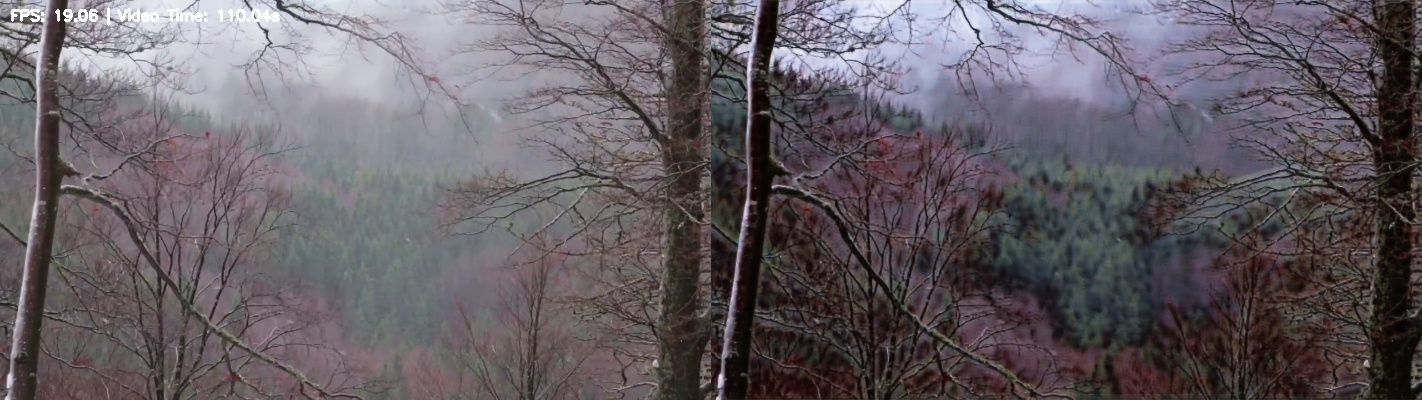

In [11]:
cap = cv2.VideoCapture(stream_url)

RESIZE = True
start_after_secs = 80
init_pbar = start_after_secs != 0
total_frames_to_skip = start_after_secs * stream_fps

early_stop, stop_after_secs = True, 30
fps = stream_fps
frames = 0

while True:
    start_time = timer()
    
    ret, frame = cap.read()
    if not ret:
        print('No frames returned.')
        break
    frames += 1
    
    if init_pbar:
        pbar = tqdm(total=start_after_secs, desc='Skipping Start')
        init_pbar = False
        
    if frames < total_frames_to_skip:
        if frames % stream_fps == stream_fps-1:
            pbar.update(1)
        continue
        
    dehazed_frame = frame_dehazer(frame, resize=RESIZE)
    cv2.putText(
        dehazed_frame,
        text = f'FPS: {fps:.2f} | Video Time: {round(frames / stream_fps, 2)}s',
        org = (10, 20),
        fontFace = cv2.FONT_HERSHEY_SIMPLEX,
        fontScale = 0.5,
        color = (255, 255, 255), # white
        thickness = 2
    )
    
    display(cv2_frame_to_img(dehazed_frame))
    clear_output(wait=True)

    end_time = timer()
    
    processing_time = end_time - start_time
    sleep_time = (stream_fps ** -1) - processing_time
    time.sleep(max(sleep_time, 0))
    
    total_time = timer() - start_time
    fps = total_time ** -1
    
    if early_stop and frames > (stop_after_secs * stream_fps) + total_frames_to_skip:
        break
    
cap.release()